# Getting started

Once you've chosen your scenario, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

## Mission: Scenario 2

- __Build models of total sales based on:__
    - location
    - price per bottle
    - total bottles sold
    - _You may find it useful to build models for each county, zip code, or city_
    
- __Provide a table of:__
    - The best performing stores by location type of your choice (city, county, or zip code)
    - The predictions of your model(s)
    
- __Based on your models and the table of data, recommend some general locations to the business owner, taking into account model performance.__ 
    - Validate your model's performance and ability to predict future sales using cross-validation
- __ _Bonus_ __
    - Recommend targets for volume sold and price per bottle

## Problem Statement

Using open source data on liquor sales in the state of Iowa and demographic data collected from government databases, this project explores the relationship between liquor sales and location, age, sex, ethnicity, and education. Demographic data was leveraged to determine ideal locations for new liquor stores in Iowa. By evaluating top performing stores in select demographic categories (those with the highest correlation to sales $), we aim to find meaningful predictors of success for new store locations.



## 1. Import & clean data

In [55]:
import pandas as pd
import numpy as np

In [56]:
# Load the data into a DataFrame

ils = pd.read_csv('/Users/ebzimm/GA-DSI/Projects/project-03/Iowa_Liquor_sales_sample_10pct.csv')

In [57]:
# Rename columns

ils.columns = ['date', 'store_num', 'city', 'zip', 'county_num',
       'county', 'category', 'category_name', 'vendor_num',
       'item_num', 'item_descrip', 'bottle_vol',
       'bottle_cost', 'bottle_retail', 'bottle_sold',
       'sale_dollars', 'vol_sold_liters', 'vol_sold_gallons']

In [58]:
# Convert currency to float

ils['bottle_cost']=ils['bottle_cost'].str.replace('\$', '').astype(float)
ils['bottle_retail']=ils['bottle_retail'].str.replace('\$', '').astype(float)
ils['sale_dollars'] = ils['sale_dollars'].str.replace('\$', '').astype(float)

In [59]:
# Convert dates to date_time

ils['date'] = pd.to_datetime(ils['date'])

In [60]:
# Convert zip to floats

ils['zip'] = pd.to_numeric(ils['zip'], errors='coerce')

In [61]:
# Edit text format

ils['city']=ils['city'].str.upper().str.replace('\ ', "_")
ils['county']=ils['county'].str.upper().str.replace('\ ', "_")
ils['category_name']=ils['category_name'].str.upper().str.replace('\ ', "_")
ils['item_descrip']=ils['item_descrip'].str.lower().str.replace('\ ', "_")

In [62]:
# Remove null values:

ils = ils.dropna(axis=0)

In [63]:
# Simplify categories:

def clean_cat(x):
    if "VODKA" in x:      
        return "VODKA"
    elif "BRANDIES" in x:
        return "BRANDY"
    elif "WHISKIES" in x:
        return "WHISKY"
    elif "SCOTCH" in x:
        return "WHISKY"
    elif "WHISKY" in x:
        return "WHISKY"
    elif "BOURBON" in x:
        return "WHISKY"
    elif "RYE" in x:
        return "WHISKY"
    elif "LIQUEUR" in x:
        return "LIQUEUR"
    elif "AMARETTO" in x:
        return "LIQUEUR"
    elif "ANISETTE" in x:
        return "LIQUEUR"
    elif "TRIPLE_SEC" in x:
        return "LIQUEUR"
    elif "CREME" in x:
        return "LIQUEUR"
    elif "SCHNAPPS" in x:
        return "LIQUEUR"
    elif "COCKTAILS" in x:
        return "COCKTAILS"
    elif "GIN" in x:
        return "GIN"
    elif "RUM" in x:
        return "RUM"
    elif "SPIRITS" in x:
        return "MISC_ALCOHOL"
    elif "DECANTERS" in x:
        return "NOT_ALCOHOL"
    elif "BEER" in x:
        return "BEER"
    elif "ALCOHOL" in x:
        return "MISC_ALCOHOL"
    else:
        return x

ils["category_name"]= ils["category_name"].apply(clean_cat)
ils["category_name"].unique()

array(['BRANDY', 'WHISKY', 'COCKTAILS', 'VODKA', 'GIN', 'LIQUEUR',
       'MISC_ALCOHOL', 'TEQUILA', 'RUM', 'NOT_ALCOHOL', 'BEER'], dtype=object)

In [64]:
# Restrict outliers: keep only values that are within +3 to -3 standard deviations in 'sale_dollars'

# ils = ils[np.abs(ils['sale_dollars']-ils['sale_dollars'].mean())\
#           <=(3*ils['sale_dollars'].std())] 

In [65]:
# Check data

ils.head()

,date,store_num,city,zip,county_num,county,category,category_name,vendor_num,item_num,item_descrip,bottle_vol,bottle_cost,bottle_retail,bottle_sold,sale_dollars,vol_sold_liters,vol_sold_gallons
0,2015-11-04,3717,SUMNER,50674.0,9.0,BREMER,1051100.0,BRANDY,55,54436,mr._boston_apricot_brandy,750,4.50,6.75,12,81.00,9.0,2.38
1,2016-03-02,2614,DAVENPORT,52807.0,82.0,SCOTT,1011100.0,WHISKY,395,27605,tin_cup,750,13.75,20.63,2,41.26,1.5,0.40
2,2016-02-11,2106,CEDAR_FALLS,50613.0,7.0,BLACK_HAWK,1011200.0,WHISKY,65,19067,jim_beam,1000,12.59,18.89,24,453.36,24.0,6.34
3,2016-02-03,2501,AMES,50010.0,85.0,STORY,1071100.0,COCKTAILS,395,59154,1800_ultimate_margarita,1750,9.50,14.25,6,85.50,10.5,2.77
4,2015-08-18,3654,BELMOND,50421.0,99.0,WRIGHT,1031080.0,VODKA,297,35918,five_o'clock_vodka,1750,7.20,10.80,12,129.60,21.0,5.55


## 2. Bring in external data on demographics & education by county

In [66]:
# Upload external data

dem = pd.read_csv('/Users/ebzimm/GA-DSI/Projects/project-03/IOWA_EXTERNAL_DATA.csv')

In [67]:
# Modify COUNTY_NAME column

dem['COUNTY_NAME']=dem['COUNTY_NAME'].str.replace(' COUNTY','')
dem['COUNTY_NAME']=dem['COUNTY_NAME'].str.replace(' ','_')
dem=dem.rename(columns={'COUNTY_NAME':'county'})

In [68]:
# Merge the datasets

merge = pd.merge(ils,dem, how='inner', on=['county'])

In [69]:
# Check the data

print merge.dtypes
print ""
merge.head()

date                             datetime64[ns]
store_num                                 int64
city                                     object
zip                                     float64
county_num                              float64
county                                   object
category                                float64
category_name                            object
vendor_num                                int64
item_num                                  int64
item_descrip                             object
bottle_vol                                int64
bottle_cost                             float64
bottle_retail                           float64
bottle_sold                               int64
sale_dollars                            float64
vol_sold_liters                         float64
vol_sold_gallons                        float64
COUNTY_NUM                                int64
POP_%GROWTH_2010-2015                   float64
RESIDENTIAL_%GROWTH_2010-2015           

,date,store_num,city,zip,county_num,county,category,category_name,vendor_num,item_num,...,AGE_0-19,AGE_20-34,AGE _35-49,AGE_50-64,AGE_65_UP,%_AGE_0-19,%_AGE_20-34,%_AGE _35-49,%_AGE_50-64,%_AGE_65_UP
0,2015-11-04,3717,SUMNER,50674.0,9.0,BREMER,1051100.0,BRANDY,55,54436,...,6517,4480,4393,4694,4192,0.268454,0.184544,0.180961,0.19336,0.172681
1,2015-06-10,3717,SUMNER,50674.0,9.0,BREMER,1051100.0,BRANDY,55,54436,...,6517,4480,4393,4694,4192,0.268454,0.184544,0.180961,0.19336,0.172681
2,2016-02-24,4670,TRIPOLI,50676.0,9.0,BREMER,1011300.0,WHISKY,85,26827,...,6517,4480,4393,4694,4192,0.268454,0.184544,0.180961,0.19336,0.172681
3,2016-02-02,2651,WAVERLY,50677.0,9.0,BREMER,1071100.0,COCKTAILS,395,58838,...,6517,4480,4393,4694,4192,0.268454,0.184544,0.180961,0.19336,0.172681
4,2015-03-10,2651,WAVERLY,50677.0,9.0,BREMER,1022100.0,TEQUILA,434,89387,...,6517,4480,4393,4694,4192,0.268454,0.184544,0.180961,0.19336,0.172681


## 3. Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [70]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

### a. Counties

In [71]:
# County and city key metrics, sorted by sum of sale dollars

merge.pivot_table(values="sale_dollars", index=["county"],\
        aggfunc=(max, min, np.mean, 'count', np.median, sum)).sort_values(ascending=False, by='sum').head(10)

,max,min,mean,count,median,sum
county,,,,,,
POLK,36392.40,1.34,158.287410,48944,77.980,7.747219e+06
LINN,15414.00,1.50,133.833411,23462,70.560,3.139999e+06
SCOTT,7593.78,1.73,147.761716,16630,75.000,2.457277e+06
JOHNSON,29327.76,1.46,157.855950,13163,86.080,2.077858e+06
BLACK_HAWK,7176.00,1.73,128.277892,15030,70.560,1.928017e+06
POTTAWATTAMIE,16542.00,1.70,140.578914,9088,74.250,1.277581e+06
WOODBURY,14887.80,2.70,146.296023,8541,83.040,1.249514e+06
DUBUQUE,6435.00,3.63,139.086347,7739,75.060,1.076389e+06
STORY,9156.00,4.38,120.043206,8944,66.075,1.073666e+06


In [72]:
# County and city key metrics, sorted by sum of sale dollars

merge.pivot_table(values="sale_dollars", index=["county","city"],\
        aggfunc=(max, min, np.mean, 'count', np.median, sum)).sort_values(ascending=False, by='sum').head(20)

,,max,min,mean,count,median,sum
county,city,,,,,,
POLK,DES_MOINES,36392.40,1.46,184.863765,23715,84.840,4384044.19
LINN,CEDAR_RAPIDS,15414.00,1.50,132.736394,18736,67.475,2486949.08
SCOTT,DAVENPORT,7593.78,1.73,148.025359,11469,80.640,1697702.84
JOHNSON,IOWA_CITY,16542.00,3.08,157.554320,7938,88.590,1250666.19
BLACK_HAWK,WATERLOO,7176.00,2.57,144.651809,8376,78.120,1211603.55
WOODBURY,SIOUX_CITY,14887.80,2.70,152.206772,7888,87.120,1200607.02
POTTAWATTAMIE,COUNCIL_BLUFFS,16542.00,1.70,148.299281,8037,77.220,1191881.32
STORY,AMES,9156.00,4.38,130.061124,7534,70.560,979880.51
DUBUQUE,DUBUQUE,6435.00,3.63,141.599850,6915,75.000,979162.96


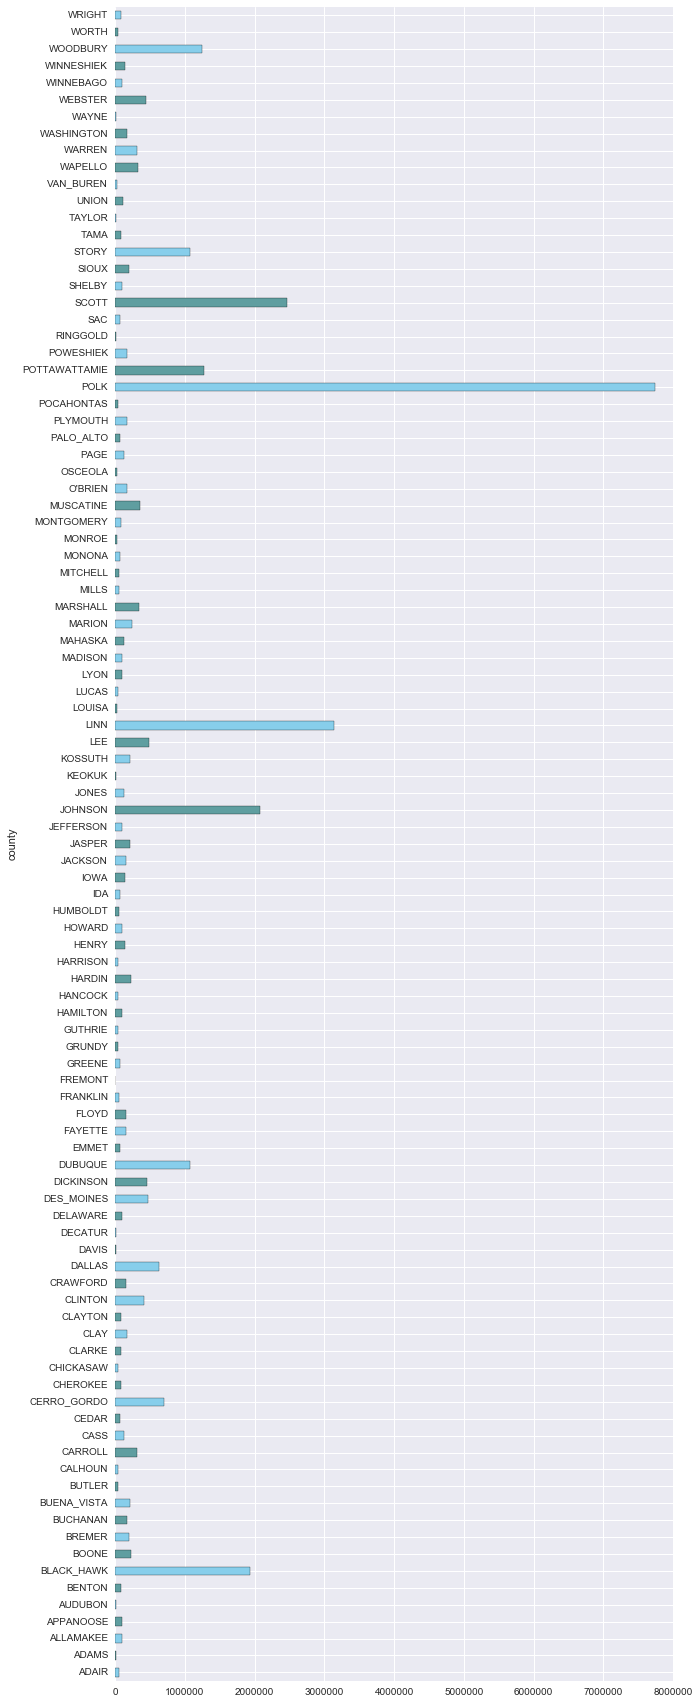

In [73]:
# Graph sum of sales by county to indicate top grossing counties

ils.pivot_table(values="sale_dollars", index="county", aggfunc=("sum"))\
                .plot(kind='barh', color=["skyblue", "cadetblue"], figsize=(10,30))

### b. Cities

In [74]:
# City key metrics, sorted by sum of sales

ils.pivot_table(values="sale_dollars", index="city", \
                aggfunc=(max, min, np.mean, 'count', np.median, sum)).sort_values(ascending=False, by='sum').head(20)

,max,min,mean,count,median,sum
city,,,,,,
DES_MOINES,36392.40,1.46,184.863765,23715,84.840,4384044.19
CEDAR_RAPIDS,15414.00,1.50,132.736394,18736,67.475,2486949.08
DAVENPORT,7593.78,1.73,148.025359,11469,80.640,1697702.84
IOWA_CITY,16542.00,3.08,157.554320,7938,88.590,1250666.19
WATERLOO,7176.00,2.57,144.651809,8376,78.120,1211603.55
SIOUX_CITY,14887.80,2.70,152.206772,7888,87.120,1200607.02
COUNCIL_BLUFFS,16542.00,1.70,148.299281,8037,77.220,1191881.32
WEST_DES_MOINES,32184.00,4.83,165.283900,7148,81.000,1181449.32
AMES,9156.00,4.38,130.061124,7534,70.560,979880.51


### c. Categories

In [75]:
# Category key metrics, sorted by sum of sale dollars

ils.pivot_table(values="sale_dollars", index="category_name", \
                aggfunc=(max, min, np.mean, 'count', np.median, sum)).sort_values(ascending=False, by='sum')

,max,min,mean,count,median,sum
category_name,,,,,,
WHISKY,36392.40,1.80,148.133350,74088,82.26,1.097490e+07
VODKA,32184.00,1.70,119.701154,69663,64.80,8.338741e+06
LIQUEUR,10902.00,1.34,118.343538,45867,58.68,5.428063e+06
RUM,16200.00,3.20,155.581396,22576,103.98,3.512406e+06
GIN,10800.00,1.34,98.422024,19892,70.56,1.957811e+06
TEQUILA,13701.60,4.50,156.153050,12043,81.00,1.880551e+06
BRANDY,4082.40,1.50,96.877559,14970,65.04,1.450257e+06
COCKTAILS,7380.00,4.50,82.681021,6877,58.50,5.685974e+05
NOT_ALCOHOL,15213.12,4.50,266.951312,1151,130.80,3.072610e+05


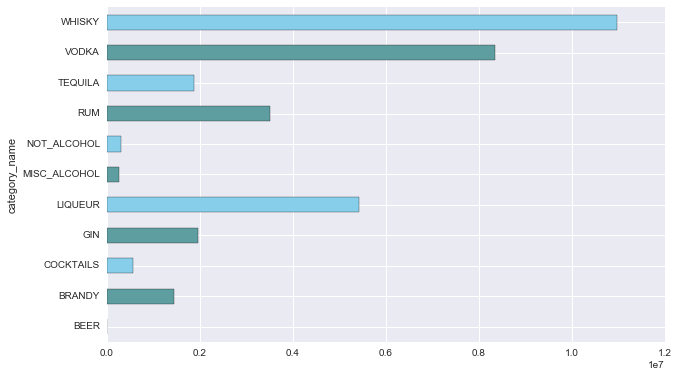

In [76]:
# Graph sum of sales by category to indicate top grossing products

ils.pivot_table(values="sale_dollars", index="category_name", aggfunc=("sum"))\
                .plot(kind='barh', color=["skyblue", "cadetblue"], figsize=(10,6))


# 4. Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

In [77]:
# Convert pivot table of key metrics by county to dataframe & merge with external data

county_df = pd.DataFrame(merge.pivot_table(values="sale_dollars", index="county",\
    aggfunc=(np.sum, 'count', min, max, np.mean, np.median)).sort_values(ascending=False, by="sum"))

county_df.columns = ['sum_sales', 'count_sales', 'min_sales', 'max_sales', 'mean_sales', 'median_sales']

df2 = county_df.reset_index()

county_dem = pd.merge(df2, dem, how='inner', on=['county'])

county_dem.head()

,county,sum_sales,count_sales,min_sales,max_sales,mean_sales,median_sales,COUNTY_NUM,POP_%GROWTH_2010-2015,RESIDENTIAL_%GROWTH_2010-2015,...,AGE_0-19,AGE_20-34,AGE _35-49,AGE_50-64,AGE_65_UP,%_AGE_0-19,%_AGE_20-34,%_AGE _35-49,%_AGE_50-64,%_AGE_65_UP
0,POLK,7.747219e+06,48944,1.34,36392.40,158.287410,77.98,153,0.081988,0.061244,...,120932,96365,90428,76370,46545,0.280819,0.223772,0.209985,0.177341,0.108083
1,LINN,3.139999e+06,23462,1.50,15414.00,133.833411,70.56,113,0.038927,-0.016454,...,58488,43066,42832,39352,27488,0.276898,0.203886,0.202778,0.186303,0.130135
2,SCOTT,2.457277e+06,16630,1.73,7593.78,147.761716,75.00,163,0.038505,0.044991,...,44829,32592,32846,33352,21605,0.271323,0.197259,0.198797,0.201859,0.130762
3,JOHNSON,2.077858e+06,13163,1.46,29327.76,157.855950,86.08,103,0.098712,0.020109,...,32994,43548,22404,20725,11211,0.252090,0.332727,0.171177,0.158349,0.085657
4,BLACK_HAWK,1.928017e+06,15030,1.73,7176.00,128.277892,70.56,13,0.017389,-0.064019,...,33970,32377,21961,24651,18131,0.259135,0.246983,0.167526,0.188046,0.138310


In [78]:
# Counties with highest # of university students

merge.pivot_table(values='UNIVERSITY_STUDENT_ENROLL', index='county',\
    aggfunc=(np.sum)).sort_values(ascending=False).head(10)

county
POLK             2586445680
SCOTT            1711942090
LINN              647035036
JOHNSON           449858688
BLACK_HAWK        382453380
STORY             327019472
WOODBURY          115329123
POTTAWATTAMIE      87117568
DUBUQUE            44746898
CERRO_GORDO        28073040
Name: UNIVERSITY_STUDENT_ENROLL, dtype: int64

In [79]:
merge.pivot_table(values='%_AGE_0-19', index='county',\
    aggfunc=(np.sum)).sort_values(ascending=False).head(20)

county
POLK             13744.417176
LINN              6496.574541
SCOTT             4512.094306
BLACK_HAWK        3894.798223
JOHNSON           3318.256313
WOODBURY          2549.794285
POTTAWATTAMIE     2474.182099
STORY             2304.471910
DUBUQUE           2095.619362
CERRO_GORDO       1556.039953
MUSCATINE         1141.400163
DES_MOINES        1043.655798
CLINTON            934.686192
WAPELLO            913.396716
MARSHALL           835.340876
DALLAS             831.685689
LEE                815.636245
WEBSTER            815.423564
BUENA_VISTA        789.623148
MARION             744.637666
Name: %_AGE_0-19, dtype: float64

In [80]:
merge.pivot_table(values='%_AGE_20-34', index='county',\
    aggfunc=(np.sum)).sort_values(ascending=False).head(20)

county
POLK             10952.276995
LINN              4783.570634
JOHNSON           4379.687989
BLACK_HAWK        3712.154325
SCOTT             3280.425119
STORY             3157.898641
WOODBURY          1710.757987
POTTAWATTAMIE     1696.671201
DUBUQUE           1479.741949
CERRO_GORDO       1059.639873
MUSCATINE          695.497132
DES_MOINES         689.865593
WAPELLO            656.253644
WEBSTER            602.118224
CLINTON            589.528808
LEE                555.572946
DALLAS             551.223543
BUENA_VISTA        517.679369
MARSHALL           509.690809
DICKINSON          484.341032
Name: %_AGE_20-34, dtype: float64

In [81]:
merge.pivot_table(values='%_AGE _35-49', index='county',\
    aggfunc=(np.sum)).sort_values(ascending=False).head(10)

county
POLK             10277.512594
LINN              4757.579008
SCOTT             3305.990535
BLACK_HAWK        2517.917689
JOHNSON           2253.204049
POTTAWATTAMIE     1783.787542
WOODBURY          1615.544046
DUBUQUE           1465.694031
STORY             1283.036790
CERRO_GORDO       1178.770127
Name: %_AGE _35-49, dtype: float64

In [82]:
merge.pivot_table(values='POP_ESTIMATE2015', index='county',\
    aggfunc=(np.sum)).sort_values(ascending=False).head(10)

county
POLK             22891647184
LINN              5159669192
SCOTT             2862455380
BLACK_HAWK        2005828650
JOHNSON           1898775913
WOODBURY           877861062
STORY              858811824
POTTAWATTAMIE      851282048
DUBUQUE            751650375
CERRO_GORDO        273588120
Name: POP_ESTIMATE2015, dtype: int64

In [83]:
# create data frame with county, city, store key metrics, merge with demographic information

county_cities = pd.DataFrame(merge.pivot_table(values="sale_dollars", index=["county","city","store_num"],\
        aggfunc=(max, min, np.mean, 'count', np.median, sum)).sort_values(ascending=False, by='sum').head(20))

county_cities = county_cities.reset_index()

county_cities = pd.merge(county_cities, dem, how='inner', on=['county'])

county_cities

,county,city,store_num,max,min,mean,count,median,sum,COUNTY_NUM,...,AGE_0-19,AGE_20-34,AGE _35-49,AGE_50-64,AGE_65_UP,%_AGE_0-19,%_AGE_20-34,%_AGE _35-49,%_AGE_50-64,%_AGE_65_UP
0,POLK,DES_MOINES,2633,36392.40,4.50,493.062483,2465,175.56,1215399.02,153,...,120932,96365,90428,76370,46545,0.280819,0.223772,0.209985,0.177341,0.108083
1,POLK,DES_MOINES,4829,13233.60,6.00,473.497540,2285,217.80,1081941.88,153,...,120932,96365,90428,76370,46545,0.280819,0.223772,0.209985,0.177341,0.108083
2,POLK,WINDSOR_HEIGHTS,3420,16200.00,38.40,934.331549,426,315.00,398025.24,153,...,120932,96365,90428,76370,46545,0.280819,0.223772,0.209985,0.177341,0.108083
3,POLK,URBANDALE,2663,15930.00,9.90,209.546096,958,122.28,200745.16,153,...,120932,96365,90428,76370,46545,0.280819,0.223772,0.209985,0.177341,0.108083
4,POLK,WEST_DES_MOINES,2648,3967.92,4.95,133.497238,1441,81.00,192369.52,153,...,120932,96365,90428,76370,46545,0.280819,0.223772,0.209985,0.177341,0.108083
5,JOHNSON,IOWA_CITY,2512,16542.00,7.26,302.954085,1755,137.16,531684.42,103,...,32994,43548,22404,20725,11211,0.252090,0.332727,0.171177,0.158349,0.085657
6,JOHNSON,CORALVILLE,2670,6444.00,4.95,187.446083,1501,113.76,281356.57,103,...,32994,43548,22404,20725,11211,0.252090,0.332727,0.171177,0.158349,0.085657
7,LINN,CEDAR_RAPIDS,3385,15414.00,64.02,854.334288,590,256.68,504057.23,113,...,58488,43066,42832,39352,27488,0.276898,0.203886,0.202778,0.186303,0.130135
8,LINN,CEDAR_RAPIDS,3773,2538.72,7.05,254.193097,1172,158.40,297914.31,113,...,58488,43066,42832,39352,27488,0.276898,0.203886,0.202778,0.186303,0.130135
9,LINN,MOUNT_VERNON,5102,3542.40,8.31,277.738437,851,166.56,236355.41,113,...,58488,43066,42832,39352,27488,0.276898,0.203886,0.202778,0.186303,0.130135


# 5. Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

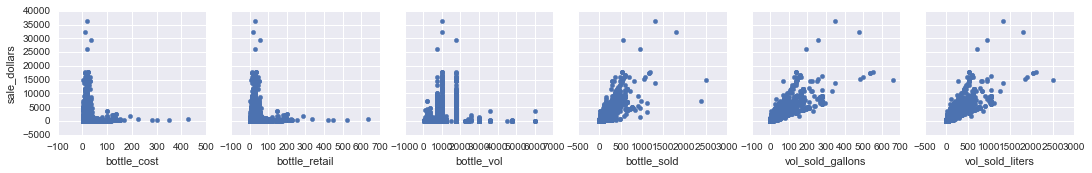

In [84]:
# Correlations ... 

pair2 = sns.PairGrid(data=ils, y_vars="sale_dollars", x_vars=("bottle_cost", "bottle_retail", \
                    "bottle_vol", "bottle_sold", "vol_sold_gallons", "vol_sold_liters"))
pair2 = pair2.map(plt.scatter)

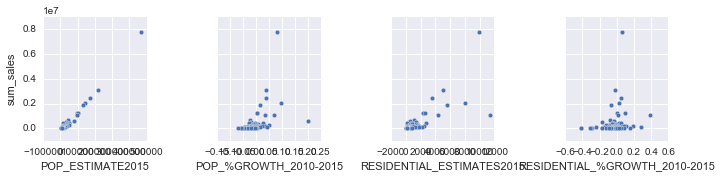

In [85]:
# Correlations by population/development indicators

sns.pairplot(county_dem, y_vars=['sum_sales'],x_vars=['POP_ESTIMATE2015','POP_%GROWTH_2010-2015', \
            'RESIDENTIAL_ESTIMATES2015', 'RESIDENTIAL_%GROWTH_2010-2015'])


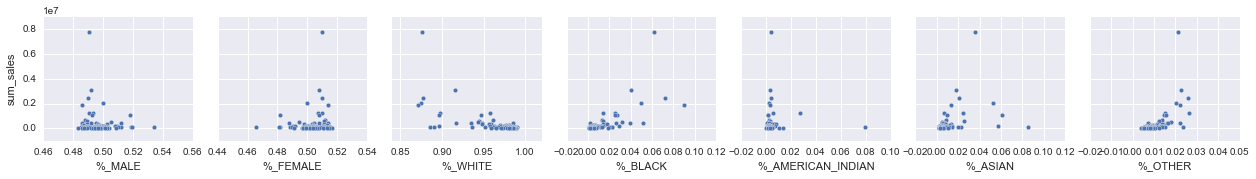

In [86]:
# Correlations by sex/race

sns.pairplot(county_dem, y_vars=['sum_sales'],\
             x_vars=['%_MALE','%_FEMALE','%_WHITE','%_BLACK','%_AMERICAN_INDIAN','%_ASIAN','%_OTHER'])


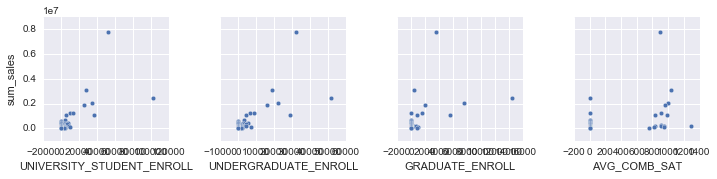

In [87]:
# Correlations by educational indicators

sns.pairplot(county_dem, y_vars=['sum_sales'],\
             x_vars=['UNIVERSITY_STUDENT_ENROLL','UNDERGRADUATE_ENROLL','GRADUATE_ENROLL','AVG_COMB_SAT'])


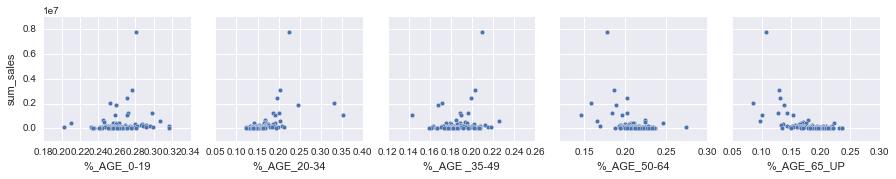

In [88]:
# Correlations by age bracket

sns.pairplot(county_dem, y_vars=['sum_sales'],\
             x_vars=['%_AGE_0-19','%_AGE_20-34','%_AGE _35-49','%_AGE_50-64', '%_AGE_65_UP'])


# 6. Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

### a. Model with original data set

R^2: 0.717511060647
tts R2:      0.745998359662


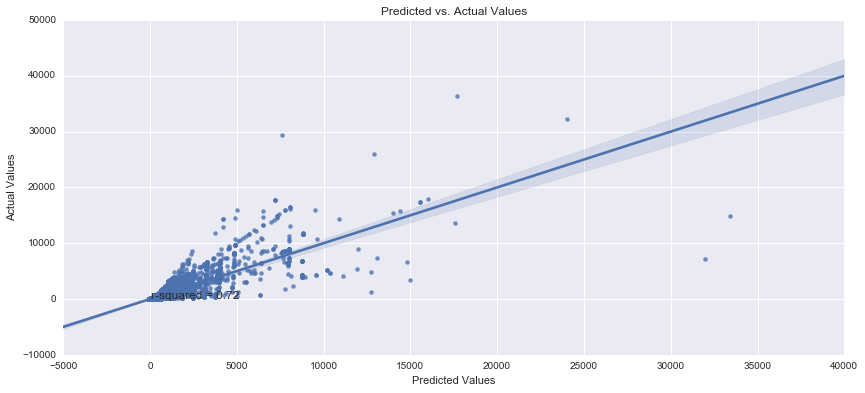

In [89]:
#regression on original data - no regularization

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
from sklearn.cross_validation import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

columns = ('bottle_cost', 'bottle_sold')
X = pd.DataFrame(merge, columns=columns)
y = pd.Series(merge["sale_dollars"])
# import our estimator
lr = linear_model.LinearRegression()
# fit our model using our data and target
lr_model = lr.fit(X, y)

y_true = y
y_pred = lr_model.predict(X)

lr_r2 =  r2_score(y_true, y_pred)
print "R^2: " + str(lr_r2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33)

lr_model = lr.fit(X,y)

y_tts = y_test
y_pred_tts = lr_model.predict(X_test)

tts_model_r2 =  r2_score(y_tts, y_pred_tts)

print 'tts R2:     ', tts_model_r2

%matplotlib inline

ax = sns.regplot(y_pred, y_true)
ax.figure.set_figheight(6)
ax.figure.set_figwidth(14)
plt.annotate('r-squared = ' + str(round(lr_r2,2)), xy=(41,-7), fontsize=12)
ax.set_ylabel('Actual Values')
ax.set_xlabel('Predicted Values')
ax.set_title('Predicted vs. Actual Values');

### b. Model with external information (demographics)

MSE: 7573576621.86
R2: 0.990716498871


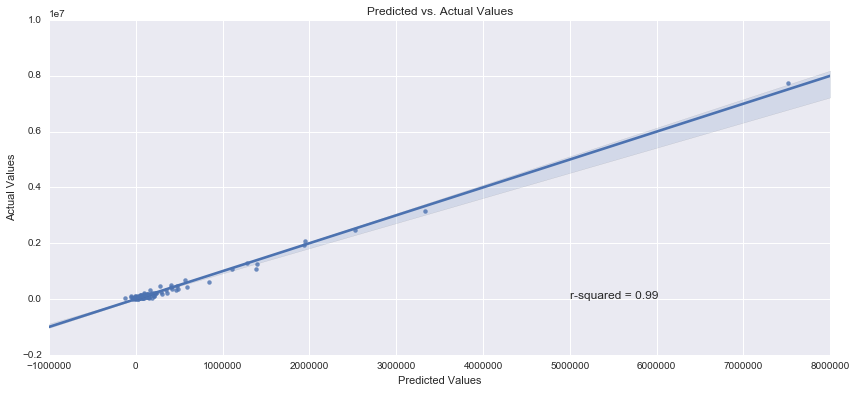

In [90]:
# Linear model with demographic indicators

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf

lm = linear_model.LinearRegression()

X = county_dem[['UNDERGRADUATE_ENROLL', 'GRADUATE_ENROLL', 'OTHER_ENROLL','POP_ESTIMATE2015','%_AGE_0-19','%_AGE_20-34', '%_AGE _35-49']]
y = county_dem['sum_sales']

model = lm.fit(X, y)
predictions = lm.predict(X)

y_true = y
y_pred = model.predict(X)

lr_r2 =  r2_score(y_true=y_true, y_pred=y_pred)

print 'MSE:', mean_squared_error(y, predictions)
print 'R2:', lr_r2

ax = sns.regplot(y_pred, y_true)
ax.figure.set_figheight(6)
ax.figure.set_figwidth(14)
plt.annotate('r-squared = ' + str(round(lr_r2,2)), xy=(5000000,0), fontsize=12)
ax.set_ylabel('Actual Values')
ax.set_xlabel('Predicted Values')
ax.set_title('Predicted vs. Actual Values');

# print summary
# break into training data and regular data

In [91]:
# Lasso

X = county_dem[['AGE_0-19','AGE_20-34','AGE _35-49','POP_ESTIMATE2015', 'GRADUATE_ENROLL', 'OTHER_ENROLL','UNDERGRADUATE_ENROLL']]
y = county_dem["sum_sales"]

lasso = linear_model.Lasso(alpha=1.0, tol=0.001)
lasso_model = lasso.fit(X, y)

y_true = y
y_pred = lasso_model.predict(X)

r_r2 =  r2_score(y_true, y_pred)

print "R2: " + str(r_r2)

R2: 0.989905570326


/Users/ebzimm/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


original linear r2: 0.990716498871
tts Lasso r2:      0.783688730794


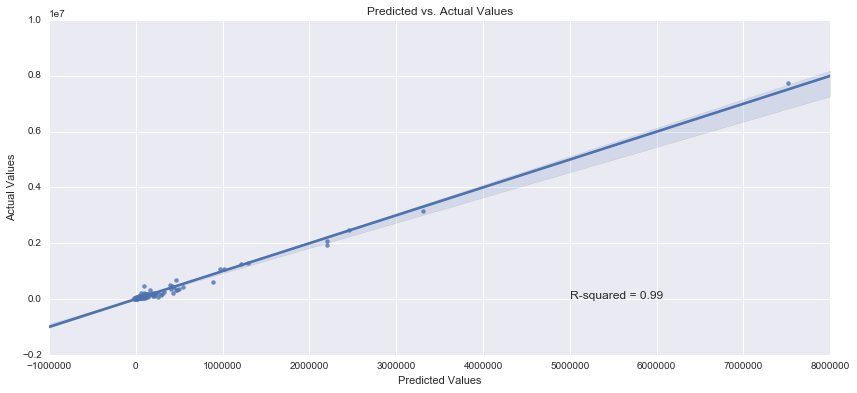

In [92]:
# Lasso cross val and graph

from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33)

lasso_model = lasso.fit(X,y)
tts_model = lasso.fit(X_train, y_train)

y_tts = y_test
y_pred_tts = lasso_model.predict(X_test)

tts_model_r2 =  r2_score(y_tts, y_pred_tts)

print 'original linear r2:', lr_r2
print 'tts Lasso r2:     ', tts_model_r2

%matplotlib inline

ax = sns.regplot(y_pred, y_true)
ax.figure.set_figheight(6)
ax.figure.set_figwidth(14)
plt.annotate('R-squared = ' + str(round(r_r2,2)), xy=(5000000,0), fontsize=12)
ax.set_ylabel('Actual Values')
ax.set_xlabel('Predicted Values')
ax.set_title('Predicted vs. Actual Values');

# Present the Results

_Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up._

After mining the dataset for correlating variables, we found the highest predictors of liquor sales were proximity to universities, young populations (all ages under 35 years old), and total population size. 

Based on these discoveries, we recommend exploring new locations in the following places: 

- __Polk County__ - all correlating factors are high in this county; however further research should be done to determine if market is over-saturated
- __Linn County__ - all correlating factors are high in this county; however further research should be done to determine if market is over-saturated
- __Scott County__ - all correlating factors are high in this county; however further research should be done to determine if market is over-saturated
- __Black Hawk County__ - all correlating factors are high in this county; however further research should be done to determine if market is over-saturated
- __Johnson County__ - large student and young populaton, relatively few stores comp to population density
